In [ ]:
import pandas as pd

df = pd.read_csv("Data2.csv")

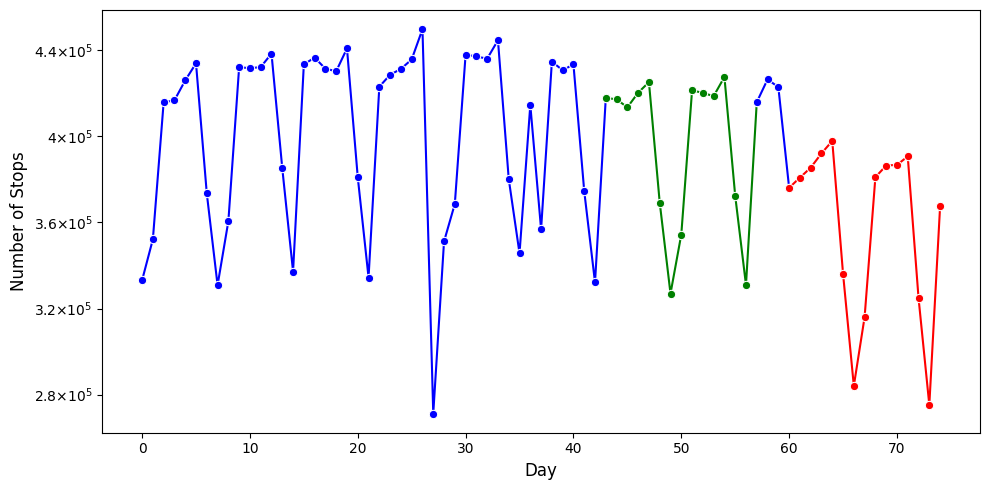

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Prepare the data
df_day = df.groupby("d").size().reset_index(name="count")

# Create masks for the three segments
blue_mask_1 = df_day['d'] < 44
yellow_mask = (df_day['d'] >= 43) & (df_day['d'] <= 57)
blue_mask_2 = (df_day['d'] > 56) & (df_day['d'] < 61)
red_mask = df_day['d'] >= 60

# Create the plot
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Plot each segment separately
sns.lineplot(data=df_day[blue_mask_1], x="d", y="count", marker="o", color='b', ax=ax, label="Normal")
sns.lineplot(data=df_day[yellow_mask], x="d", y="count", marker="o", color='g', ax=ax, label="Emergency")
sns.lineplot(data=df_day[blue_mask_2], x="d", y="count", marker="o", color='b', ax=ax)  # Continue blue after emergency
sns.lineplot(data=df_day[red_mask], x="d", y="count", marker="o", color='r', ax=ax, label="Post-Emergency")

# Custom formatter for scientific notation
def sci_formatter(x, pos):
    if x == 0:
        return "0"
    exponent = int(np.log10(abs(x)))
    coeff = x / 10**exponent
    return f"{coeff:g}×10$^{{{exponent}}}$"

# Apply the formatter to y-axis
ax.yaxis.set_major_formatter(FuncFormatter(sci_formatter))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.legend_.remove()

# Labels and styling
plt.xlabel("Day", fontsize=12)
plt.ylabel("Number of Stops", fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.savefig('activity_plot.png', dpi=300)

plt.show()


In [82]:
# Create a mapping for days of the week (Sunday as 1, Monday as 2, ..., Saturday as 7)
days_mapping = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7}

# Apply the mapping
df["day_of_week"] = df["d"].map(lambda x: days_mapping[x % 7])

# Display the first few rows to check
print(df.head())


   uid  d  t    x   y  day_of_week
0    0  0  0  163  60            1
1    0  0  1  163  60            1
2    0  0  2  163  61            1
3    0  0  5  163  60            1
4    0  0  8  163  61            1


In [83]:
# Define additional holiday days
additional_holidays = {0,1,6,7,8,13,14,20,21,27,28,29,34,35,37,41,42,48,49,50,55,56}

# Identify weekend days (Sunday = 1, Saturday = 7)
weekend_days = {1, 7}

# Efficiently mark holidays using vectorized operations
df["holiday"] = df["d"].isin(additional_holidays) | df["day_of_week"].isin(weekend_days)
df["holiday"] = df["holiday"].astype(int)

# Mark weekends separately
df["weekend"] = df["day_of_week"].isin(weekend_days).astype(int)

# Display the first few rows to check
print(df.head())


   uid  d  t    x   y  day_of_week  holiday  weekend
0    0  0  0  163  60            1        1        1
1    0  0  1  163  60            1        1        1
2    0  0  2  163  61            1        1        1
3    0  0  5  163  60            1        1        1
4    0  0  8  163  61            1        1        1


In [84]:
import pandas as pd

# --- Step 1: Use only d < 60 for location inference ---
df_filtered = df[df['d'] < 60]

# --- Step 2: Compute HOME location (8PM–8AM) ---
home_df = df_filtered[(df_filtered['t'] >= 40) | (df_filtered['t'] < 16)]
home_loc = (
    home_df.groupby(['uid', 'x', 'y'])
    .size()
    .reset_index(name='count')
    .sort_values(['uid', 'count'], ascending=[True, False])
    .drop_duplicates('uid')
    .rename(columns={'x': 'x_h', 'y': 'y_h'})
    .drop(columns='count')
)

# --- Step 3: Compute WORK location (8AM–5PM on weekdays) ---
work_df = df_filtered[(df_filtered['t'] >= 16) & (df_filtered['t'] <= 34) & (df_filtered['holiday'] == 0)]
work_loc = (
    work_df.groupby(['uid', 'x', 'y'])
    .size()
    .reset_index(name='count')
    .sort_values(['uid', 'count'], ascending=[True, False])
    .drop_duplicates('uid')
    .rename(columns={'x': 'x_w', 'y': 'y_w'})
    .drop(columns='count')
)

# --- Step 4: Merge both location dataframes ---
location_df = pd.merge(home_loc, work_loc, on='uid', how='outer')

# --- Step 5: Merge back into the full df ---
df = df.merge(location_df, on='uid', how='left')

# Show result
print(df.head())


   uid  d  t    x   y  day_of_week  holiday  weekend    x_h   y_h    x_w   y_w
0    0  0  0  163  60            1        1        1  163.0  61.0  163.0  61.0
1    0  0  1  163  60            1        1        1  163.0  61.0  163.0  61.0
2    0  0  2  163  61            1        1        1  163.0  61.0  163.0  61.0
3    0  0  5  163  60            1        1        1  163.0  61.0  163.0  61.0
4    0  0  8  163  61            1        1        1  163.0  61.0  163.0  61.0


In [85]:
import numpy as np

# Sort values
df = df.sort_values(['uid', 'd', 't']).reset_index(drop=True)

# Compute time index
df['time_index'] = df['d'] * 48 + df['t']

# Shift for next time for time_spent
df['next_time'] = df.groupby('uid')['time_index'].shift(-1)
df['time_spent'] = (df['next_time'] - df['time_index']) * 0.5
df['time_spent'] = df['time_spent'].clip(lower=0, upper=5).fillna(0)

# Shift for previous x/y for dist
df['prev_x'] = df.groupby('uid')['x'].shift(1)
df['prev_y'] = df.groupby('uid')['y'].shift(1)
dx = df['x'] - df['prev_x']
dy = df['y'] - df['prev_y']
df['dist'] = np.sqrt(dx**2 + dy**2) * 0.5  # 500m per grid = 0.5 km
df['dist'] = df['dist'].fillna(0)

# Drop helper columns
df.drop(columns=['time_index', 'next_time', 'prev_x', 'prev_y'], inplace=True)

# Show result
print(df.head())


   uid  d  t    x   y  day_of_week  holiday  weekend    x_h   y_h    x_w  \
0    0  0  0  163  60            1        1        1  163.0  61.0  163.0   
1    0  0  1  163  60            1        1        1  163.0  61.0  163.0   
2    0  0  2  163  61            1        1        1  163.0  61.0  163.0   
3    0  0  5  163  60            1        1        1  163.0  61.0  163.0   
4    0  0  8  163  61            1        1        1  163.0  61.0  163.0   

    y_w  time_spent  dist  
0  61.0         0.5   0.0  
1  61.0         0.5   0.0  
2  61.0         1.5   0.5  
3  61.0         1.5   0.5  
4  61.0         0.5   0.5  


walk_d_home is used to define nearby neighborhoods relative to the home location.

In [86]:
def compute_walk_distance(df):
    # Calculate walk_d_home with proper parentheses
    df['walk_d_home'] = ((abs(df['x'] - df['x_h']) <= 2) & (abs(df['y'] - df['y_h']) <= 2))
    df['walk_d_home'] = df['walk_d_home'].astype(int)
    
    return df

# Apply the optimized function
df = compute_walk_distance(df)

In [89]:
# Convert to numpy arrays for faster computation
walk_d_home = df['walk_d_home'].values

# Pre-allocate result arrays
out_home_trip = np.zeros(len(df), dtype=int)

# Vectorized computation
out_home_trip[1:] = (walk_d_home[:-1] == 1) & (walk_d_home[1:] == 0)

# Assign back to DataFrame
df['out_home_trip'] = out_home_trip


In [91]:
df['xy_h_location'] = (df['x_h'] - 1) * 200 + df['y_h']
df['xy_location'] = (df['x'] - 1) * 200 + df['y']


In [42]:
# Split df_2 based on the value of 'd'
#df_2_usual = df[df['d'] < 60].copy()
df_2_usual = df[(df['d'] >= 43) & (df['d'] <= 57)].copy()
df_2_emergency = df[df['d'] >= 60].copy()


In [36]:
df_2_usual.to_parquet("df_15usualDays", engine="pyarrow", index=False)
df_2_emergency.to_parquet("df_15emergencyDays", engine="pyarrow", index=False)


In [ ]:
df_2_usual.to_parquet("df_2_usual_explorerer.parquet", compression='snappy')


# Explorers VS Returners

In [ ]:
df_2_usual_explorerer = pd.read_parquet("df_2_usual_explorerer.parquet")

In [1]:
import pandas as pd

def collapse_by_uid_chunks(df, chunk_size=1000):
    collapsed_chunks = []
    uids = df['uid'].unique()

    for i in range(0, len(uids), chunk_size):
        uid_chunk = uids[i:i + chunk_size]
        df_chunk = df[df['uid'].isin(uid_chunk)].sort_values(['uid', 'd', 't'])

        result = []
        last_uid = None
        last_loc = None
        current_row = None

        for row in df_chunk.itertuples(index=False):
            if row.uid == last_uid and row.xy_location == last_loc:
                current_row['time_spent'] += row.time_spent
            else:
                if current_row is not None:
                    result.append(current_row)
                current_row = row._asdict()

            last_uid = row.uid
            last_loc = row.xy_location

        if current_row is not None:
            result.append(current_row)

        collapsed_chunk = pd.DataFrame(result)
        collapsed_chunks.append(collapsed_chunk)

        print(f"✅ Processed {i + len(uid_chunk)} / {len(uids)} UIDs")

    return pd.concat(collapsed_chunks, ignore_index=True)


In [ ]:
df_2_usual_explorerer = collapse_by_uid_chunks(df_2_usual, chunk_size=1000)

In [43]:
import numpy as np
import pandas as pd

def compute_radius_of_gyration(df):
    """
    Compute the radius of gyration for each user in the provided DataFrame chunk.
    
    Parameters:
    df (DataFrame): DataFrame containing columns 'uid', 'x', 'y', and 'time_spent'.
    
    Returns:
    DataFrame: A DataFrame with 'uid' and their corresponding 'radius_of_gyration'.
    """
    results = []

    for uid, group in df.groupby('uid'):
        x = group['x'].values
        y = group['y'].values
        t = group['time_spent'].values

        total_time = np.sum(t)
        x_c = np.sum(x * t) / total_time
        y_c = np.sum(y * t) / total_time

        squared_distances = (x - x_c)**2 + (y - y_c)**2
        r_g_grid = np.sqrt(np.sum(t * squared_distances) / total_time)
        r_g_meters = r_g_grid * 500  # Convert grid units to meters

        results.append({'uid': uid, 'radius_of_gyration': r_g_meters})

    return pd.DataFrame(results)


In [44]:
chunk_size = 100000  # Adjust based on your system's memory capacity
aggregated_results = []

# Assuming 'df_15mcity_collapsed' is your large DataFrame
for start in range(0, len(df_2_usual_explorerer), chunk_size):
    end = start + chunk_size
    chunk = df_2_usual_explorerer.iloc[start:end]
    chunk_results = compute_radius_of_gyration(chunk)
    aggregated_results.append(chunk_results)

# Combine all chunk results
df_2_usual_results = pd.concat(aggregated_results).groupby('uid', as_index=False).mean()

print(df_2_usual_results.head())


   uid  radius_of_gyration
0    0        10232.204243
1    1         8506.139450
2    2         7156.559343
3    3        17501.391143
4    4         5957.499294


In [19]:
import numpy as np
import pandas as pd

def compute_radius_of_gyration(df):
    """
    Compute radius of gyration (r_g) and its second moment (r_g^2) for each user.
    
    Parameters:
    df (DataFrame): DataFrame containing columns 'uid', 'x', 'y', and 'time_spent'.
    
    Returns:
    DataFrame: A DataFrame with 'uid', 'radius_of_gyration', and 'radius_of_gyration_2'.
    """
    results = []

    for uid, group in df.groupby('uid'):
        x = group['x'].values
        y = group['y'].values
        t = group['time_spent'].values

        total_time = np.sum(t)
        x_c = np.sum(x * t) / total_time  # Center of mass (x)
        y_c = np.sum(y * t) / total_time  # Center of mass (y)

        squared_distances = (x - x_c)**2 + (y - y_c)**2
        
        # Standard radius of gyration (r_g)
        r_g_squared = np.sum(t * squared_distances) / total_time
        r_g_meters = np.sqrt(r_g_squared) * 500  # Convert grid units to meters
        
        # Second moment of radius of gyration (r_g^2)
        r_g_2_meters = r_g_squared * (500**2)  # Squared distances in meters²

        results.append({
            'uid': uid,
            'radius_of_gyration': r_g_meters,
            'radius_of_gyration_2': r_g_2_meters
        })

    return pd.DataFrame(results)

In [20]:
chunk_size = 100000  # Adjust based on your system's memory capacity
aggregated_results = []

# Assuming 'df_2_usual_explorerer' is your large DataFrame
for start in range(0, len(df_2_usual_explorerer), chunk_size):
    end = start + chunk_size
    chunk = df_2_usual_explorerer.iloc[start:end]
    chunk_results = compute_radius_of_gyration(chunk)
    aggregated_results.append(chunk_results)

# Combine all chunk results and average per user
df_2_usual_results = pd.concat(aggregated_results).groupby('uid', as_index=False).mean()

# Display results
print(df_2_usual_results.head())
print("\nDescriptive statistics for radius_of_gyration:")
print(df_2_usual_results['radius_of_gyration'].describe())
print("\nDescriptive statistics for radius_of_gyration_2:")
print(df_2_usual_results['radius_of_gyration_2'].describe())

   uid  radius_of_gyration  radius_of_gyration_2
0    1         7577.927692          5.742499e+07
1    2         9173.411922          8.415149e+07
2    3        17419.011236          3.034220e+08
3    4         5252.805950          2.759197e+07
4    5         4379.149597          1.917695e+07

Descriptive statistics for radius_of_gyration:
count    24675.000000
mean      9198.525677
std       5987.162504
min          0.000000
25%       4648.545824
50%       8039.248552
75%      12435.428538
max      45342.470950
Name: radius_of_gyration, dtype: float64

Descriptive statistics for radius_of_gyration_2:
count    2.467500e+04
mean     1.204740e+08
std      1.594818e+08
min      0.000000e+00
25%      2.160898e+07
50%      6.470531e+07
75%      1.546464e+08
max      2.055940e+09
Name: radius_of_gyration_2, dtype: float64


The following code generate the plot for rg.

Values less than or equal to 0 in data. Throwing out 0 or negative values


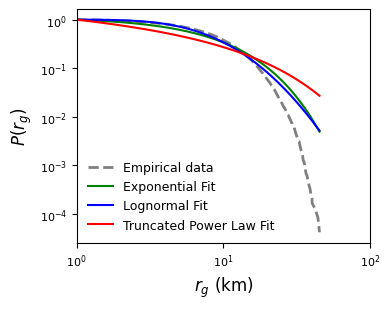

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
from matplotlib.ticker import NullLocator, LogFormatterMathtext

# === Load and fit full radius of gyration in kilometers ===
rg_m = df_2_usual_results['radius_of_gyration'].dropna().values
rg_km = rg_m / 1000.0
fit_rg = powerlaw.Fit(rg_km, xmin=1.0, discrete=False)

# === Plot ===
fig = plt.figure(figsize=(4, 3.2), dpi=100)
ax = fig.add_subplot(111)

# Empirical CCDF (dashed)
fit_rg.plot_ccdf(ax=ax, color='gray', linestyle='--', linewidth=2, label='Empirical data')

# Fitted Curves (solid)
fit_rg.exponential.plot_ccdf(ax=ax, color='green', linestyle='-', label='Exponential Fit')
fit_rg.lognormal.plot_ccdf(ax=ax, color='blue', linestyle='-', label='Lognormal Fit')
fit_rg.truncated_power_law.plot_ccdf(ax=ax, color='red', linestyle='-', label='Truncated Power Law Fit')

# Adjust axes
ax.set_xscale('log')
ax.set_xlim(1e0, 1e2)
ax.set_xticks([1e0, 1e1, 1e2])
ax.get_xaxis().set_major_formatter(LogFormatterMathtext(base=10))
ax.get_xaxis().set_minor_locator(NullLocator())
ax.get_yaxis().set_minor_locator(NullLocator())

# Labels and styling
ax.set_xlabel(r'$r_g\ (\mathrm{km})$', fontsize=12)
ax.set_ylabel(r'$P(r_g)$', fontsize=12)
#ax.set_title('Normal period', fontsize=12)
ax.legend(frameon=False, fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.grid(False)

plt.tight_layout()
plt.show()


The following code calculates the parameters.

In [9]:
import powerlaw
import pandas as pd

# === Step 1: Prepare radius of gyration in kilometers ===
rg_m = df_2_usual_results['radius_of_gyration'].dropna().values
rg_km = rg_m / 1000.0

# === Step 2: Fit data using powerlaw package with fixed xmin ===
fit = powerlaw.Fit(rg_km, xmin=1.0, discrete=False)

# === Step 3: Extract lognormal parameters ===
mu = fit.lognormal.mu
sigma = fit.lognormal.sigma
xmin = fit.lognormal.xmin

# === Step 4: Compare lognormal against truncated power law and exponential ===
R_vs_tpl, p_vs_tpl = fit.distribution_compare('lognormal', 'truncated_power_law')
R_vs_exp, p_vs_exp = fit.distribution_compare('lognormal', 'exponential')

# === Step 5: Format results in a DataFrame ===
result = pd.DataFrame([{
    "Lognormal parameters (μ, σ)": f"{mu:.4f}, {sigma:.4f}",
    "X_min": f"{xmin:.4f}",
    "Lognormal vs Truncated Power Law (R)": f"{R_vs_tpl:.4f}",
    "p-value vs Truncated Power Law": f"{p_vs_tpl:.4f}",
    "Lognormal vs Exponential (R)": f"{R_vs_exp:.4f}",
    "p-value vs Exponential": f"{p_vs_exp:.4f}"
}])

# === Step 6: Display ===
print(result.to_string(index=False))


Values less than or equal to 0 in data. Throwing out 0 or negative values


Lognormal parameters (μ, σ)  X_min Lognormal vs Truncated Power Law (R) p-value vs Truncated Power Law Lognormal vs Exponential (R) p-value vs Exponential
             2.0127, 0.7019 1.0000                            7423.1453                         0.0000                    1193.5617                 0.0000


The following code calculates the parameters for each day.

In [23]:
import numpy as np
import pandas as pd
import powerlaw

# === Function to compute radius of gyration ===
def compute_radius_of_gyration(df):
    results = []
    for uid, group in df.groupby('uid'):
        x = group['x'].values
        y = group['y'].values
        t = group['time_spent'].values
        if t.sum() == 0:
            continue
        x_c = np.sum(x * t) / np.sum(t)
        y_c = np.sum(y * t) / np.sum(t)
        squared_distances = (x - x_c)**2 + (y - y_c)**2
        r_g_grid = np.sqrt(np.sum(t * squared_distances) / np.sum(t))
        r_g_meters = r_g_grid * 500
        results.append({'uid': uid, 'radius_of_gyration': r_g_meters})
    return pd.DataFrame(results)

# === Storage for results ===
results_list = []

# === Loop over days 11 to 25 ===
for day in range(43, 58):
    df_day = df_2_usual_explorerer[df_2_usual_explorerer['d'] == day]
    rg_df = compute_radius_of_gyration(df_day)

    # Convert to km and fit distribution
    rg_km = rg_df['radius_of_gyration'].dropna().values / 1000.0
    if len(rg_km) < 10:
        continue  # skip days with insufficient data

    fit = powerlaw.Fit(rg_km, discrete=False, verbose=False)

    # Compare lognormal to others
    R_log_vs_exp, _ = fit.distribution_compare('lognormal', 'exponential')
    R_log_vs_pwr, _ = fit.distribution_compare('lognormal', 'truncated_power_law')

    mu = fit.lognormal.mu
    sigma = fit.lognormal.sigma
    xmin = fit.lognormal.xmin

    results_list.append({
        'day': day,
        'mu': mu,
        'sigma': sigma,
        'xmin': xmin,
        'lognormal_vs_exponential': R_log_vs_exp,
        'lognormal_vs_truncated_power_law': R_log_vs_pwr
    })

# === Convert to DataFrame and show results ===
results_df = pd.DataFrame(results_list)
print(results_df)


/home/wissamkontar/omida/.local/lib/python3.8/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


    day         mu     sigma       xmin  lognormal_vs_exponential  \
0    43 -56.209881  2.264775  36.075603                  0.153353   
1    44   2.514454  0.455736  13.980824                 -5.399151   
2    45   2.896070  0.332030  19.295224                  4.534811   
3    46   3.168244  0.246575  30.944816                  0.339561   
4    47 -86.556666  2.350342  38.221010                  1.403069   
5    48   2.861258  0.319097  27.994169                  0.034015   
6    49   3.111490  0.259046  34.030550                  0.101383   
7    50   3.162902  0.246044  29.293780                  0.565861   
8    51   2.686263  0.389536  16.223882                 -0.296338   
9    52   2.634831  0.419935  15.341713                 -3.123087   
10   53   2.727118  0.380160  17.030798                  0.078081   
11   54   3.114262  0.254873  26.481470                  1.621590   
12   55   3.252092  0.224659  29.319540                  1.717686   
13   56   3.181071  0.268607  26.7

The following code generates the plot for k=2. You can modify the k to generate the plot for other values of k.

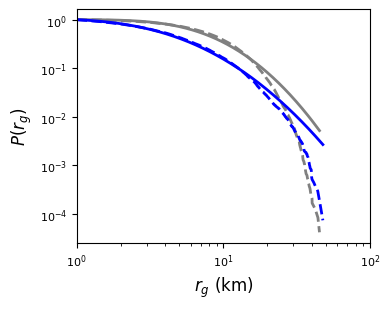

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
from matplotlib.ticker import NullLocator

# === Define k ===
k = 2  # Set k once at the beginning

# === Load and prepare full radius of gyration (in km) ===
rg_m = df_2_usual_results['radius_of_gyration'].dropna().values
rg_km = rg_m / 1000.0
fit_rg = powerlaw.Fit(rg_km, xmin=1.0, discrete=False, verbose=False)

# === Compute r_k for the defined k ===
def compute_rk(df, k):
    rk_list = []
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500 / 1000.0  # Convert to km
        rk_list.append(rk)
    return np.array(rk_list)

# === Fit r_k with the defined k ===
r2g_km = compute_rk(df_2_usual_explorerer, k)
fit_r2g = powerlaw.Fit(r2g_km, xmin=1.0, discrete=False, verbose=False)

# === Plot ===
fig = plt.figure(figsize=(4, 3.2), dpi=100)
ax = fig.add_subplot(111)

# Plot empirical CCDFs (dashed)
fit_rg.plot_ccdf(ax=ax, color='gray', linestyle='--', linewidth=2)    
fit_r2g.plot_ccdf(ax=ax, color='blue', linestyle='--', linewidth=2)  

# Plot lognormal fits (solid)
fit_rg.lognormal.plot_ccdf(ax=ax, color='gray', linestyle='-', linewidth=2)
fit_r2g.lognormal.plot_ccdf(ax=ax, color='blue', linestyle='-', linewidth=2)

# Turn off y-minor ticks
ax.yaxis.set_minor_locator(NullLocator())

# Axis formatting
ax.set_xscale('log')
ax.set_xlim(1e0, 1e2)
ax.set_xticks([1e0, 1e1, 1e2])
ax.set_xlabel(r'$r_g\ (\mathrm{km})$', fontsize=12)
ax.set_ylabel(r'$P(r_g)$', fontsize=12)
#ax.set_title(f'k={k}', fontsize=12)  # Optional: Display k value in title
ax.tick_params(axis='both', which='major', labelsize=8)
ax.grid(False)

# No legend
plt.tight_layout()
plt.show()


The following code generates the parameters for different values of k.

In [24]:
import numpy as np
import pandas as pd
import powerlaw

# === Function to compute full radius of gyration ===
def compute_r_g(df):
    results = []
    for uid, group in df.groupby('uid'):
        x = group['x'].values
        y = group['y'].values
        t = group['time_spent'].values
        if t.sum() == 0:
            continue
        x_c = np.sum(x * t) / np.sum(t)
        y_c = np.sum(y * t) / np.sum(t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        r_g = np.sqrt(np.sum(t * dist_sq) / np.sum(t)) * 500
        results.append(r_g)
    return np.array(results)

# === Function to compute top-k radius of gyration ===
def compute_r_k(df, k):
    rk_list = []
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_list.append(rk)
    return np.array(rk_list)

# === Analyze and fit lognormal for r_g and r_k ===
k_values = [1, 2, 3, 4, 5, 8]
fit_results = []

for k in k_values:
    if k == 1:
        data = compute_r_g(df_2_usual_explorerer)
        label = "r_g"
    else:
        data = compute_r_k(df_2_usual_explorerer, k)
        label = f"r_{k}"

    data_km = data / 1000.0
    fit = powerlaw.Fit(data_km, xmin=1.0, discrete=False,verbose=False)

    fit_results.append({
        'metric': label,
        'mu': fit.lognormal.mu,
        'sigma': fit.lognormal.sigma,
        'xmin': fit.lognormal.xmin,
        'n': len(data_km)
    })

# === Convert to DataFrame and display ===
fit_df = pd.DataFrame(fit_results)
print(fit_df)


  metric        mu     sigma  xmin      n
0    r_g  2.013050  0.701965   1.0  24675
1    r_2  1.349116  0.896230   1.0  24675
2    r_3  1.333392  0.900324   1.0  24675
3    r_4  1.368369  0.899088   1.0  24675
4    r_5  1.400317  0.902175   1.0  24675
5    r_8  1.544327  0.867583   1.0  24675


The following code generates the scatter plot for k=2. You can modify the k to generate other plots. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

k = 2  # Top-k locations

# === Step 1: Compute rₖg ===
def compute_rk_all(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c) ** 2 + (y - y_c) ** 2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

# === Step 2: Match with full rg ===
rk_dict = compute_rk_all(df_2_usual_explorerer, k=k)
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

common_uids = set(rg_dict).intersection(rk_dict)
rg_vals = np.array([rg_dict[uid] for uid in common_uids])
rk_vals = np.array([rk_dict[uid] for uid in common_uids])

# === Step 3: Compute density for color ===
xy = np.vstack([rg_vals, rk_vals])
z = gaussian_kde(xy)(xy)

# === Step 4: Plot ===
fig = plt.figure(figsize=(4, 3.2), dpi=100)
sc = plt.scatter(rg_vals, rk_vals, c=z, s=10, cmap='plasma', alpha=0.7)

# 45° Line (no label, no legend entry)
plt.plot([0, 60000], [0, 60000], 'k--', linewidth=1.5)

# Axes settings
plt.xlim(0, 60000)
plt.ylim(0, 60000)
tick_vals = np.arange(0, 60001, 10000)
tick_labels = [f"{x // 1000}" for x in tick_vals]
plt.xticks(tick_vals, labels=tick_labels)
plt.yticks(tick_vals, labels=tick_labels)

plt.xlabel(r"$r_g$ (km)", fontsize=12)
plt.ylabel(r"$r_g^{(2)}$ (km)", fontsize=12)
#plt.title(f'k={k}', fontsize=12)
plt.colorbar(sc, label='Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.grid(False)  # Turn off grid lines

plt.tight_layout()
plt.show()


The following code generates the plot for k=2. You can modify the k to generate other plots. 

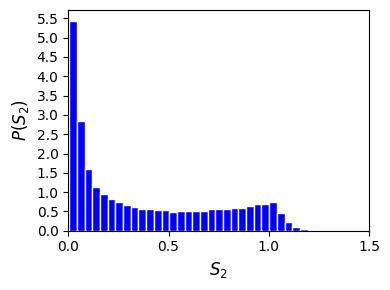

In [5]:
import numpy as np
import matplotlib.pyplot as plt

k = 2  # Top-k time-weighted locations

# === Step 1: Compute rₖg from time-based locations ===
def compute_rk_dict(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c) ** 2 + (y - y_c) ** 2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

# === Step 2: Load r_g from full mobility ===
rk_dict = compute_rk_dict(df_2_usual_explorerer, k=k)
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

# === Step 3: Compute Sₖ = rₖ / r_g ===
common_uids = set(rk_dict).intersection(rg_dict)
sk_vals = np.array([rk_dict[uid] / rg_dict[uid] for uid in common_uids if rg_dict[uid] > 0])

# === Step 4: Plot distribution of Sₖ ===
fig = plt.figure(figsize=(4, 3), dpi=100)
n, bins, patches = plt.hist(sk_vals, bins=50, density=True, color='blue', edgecolor='white')

plt.xlim(0, 1.5)
plt.xticks(np.arange(0, 1.51, 0.5))
plt.yticks(np.arange(0, max(n)+0.1, 0.5))  # Clean y-axis ticks

plt.xlabel(f"$S_{k}$", fontsize=12)
plt.ylabel(f"$P(S_{k})$", fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()


The following code generates the plot of percentages of explorers and returners.

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Function to compute radius of gyration ===
def compute_rk(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

# === Function to classify returner vs explorer ===
def classify_users(df, rg_dict, k):
    rk_dict = compute_rk(df, k)
    common_uids = set(rg_dict).intersection(rk_dict)
    result = {'returner': 0, 'explorer': 0}
    
    for uid in common_uids:
        rg = rg_dict[uid]
        rk = rk_dict[uid]
        if rg == 0:
            continue
        sk = rk / rg
        if sk > 0.5:
            result['returner'] += 1
        else:
            result['explorer'] += 1
    total = result['returner'] + result['explorer']
    result['returner_pct'] = 100 * result['returner'] / total
    result['explorer_pct'] = 100 * result['explorer'] / total
    return result

# === Load rg from results ===
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

# === Classify users for multiple k values ===
k_values = [2, 3, 4, 5, 6, 8, 10]
explorer_pcts = []
returner_pcts = []

for k in k_values:
    stats = classify_users(df_2_usual_explorerer, rg_dict, k)
    explorer_pcts.append(stats['explorer_pct'])
    returner_pcts.append(stats['returner_pct'])



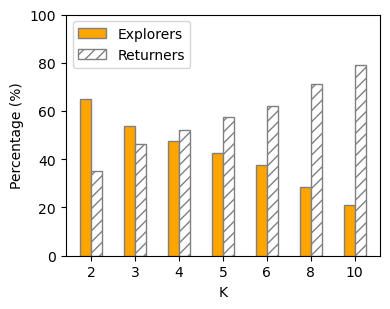

In [53]:
# === Plot ===
x = np.arange(len(k_values))
width = 0.25  # Narrower bars

plt.figure(figsize=(4, 3.2), dpi=100)
plt.bar(x - width/2, explorer_pcts, width, label='Explorers',
        color='orange', edgecolor='gray')
plt.bar(x + width/2, returner_pcts, width, label='Returners',
        color='white', edgecolor='gray', hatch='///')



plt.xticks(x, k_values)
plt.xlabel("K")
plt.ylabel("Percentage (%)")
#plt.title("Normal period")
plt.ylim(0, 100)

plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


The following code produces the plot of percentage of explorers and returners across 8 weeks. You can modify "d" values to generate the plot for different periods of normal time. 

In [76]:
df = pd.read_csv("Data2.csv")

In [147]:
df_2_usual_explorerer = df_2_usual[(df_2_usual['d'] >= 2) & (df_2_usual['d'] <= 57)]


In [149]:
chunk_size = 100000  # Adjust based on your system's memory capacity
aggregated_results = []

# Assuming 'df_15mcity_collapsed' is your large DataFrame
for start in range(0, len(df_2_usual_explorerer), chunk_size):
    end = start + chunk_size
    chunk = df_2_usual_explorerer.iloc[start:end]
    chunk_results = compute_radius_of_gyration(chunk)
    aggregated_results.append(chunk_results)

# Combine all chunk results
df_2_usual_results = pd.concat(aggregated_results).groupby('uid', as_index=False).mean()

print(df_2_usual_results.head())


   uid  radius_of_gyration
0    0         9685.169285
1    1         8346.023904
2    2         8004.384568
3    3        17661.590536
4    4         5163.434333


In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Function to compute radius of gyration ===
def compute_rk(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

# === Function to classify returner vs explorer ===
def classify_users(df, rg_dict, k):
    rk_dict = compute_rk(df, k)
    common_uids = set(rg_dict).intersection(rk_dict)
    result = {'returner': 0, 'explorer': 0}
    
    for uid in common_uids:
        rg = rg_dict[uid]
        rk = rk_dict[uid]
        if rg == 0:
            continue
        sk = rk / rg
        if sk > 0.5:
            result['returner'] += 1
        else:
            result['explorer'] += 1
    total = result['returner'] + result['explorer']
    result['returner_pct'] = 100 * result['returner'] / total
    result['explorer_pct'] = 100 * result['explorer'] / total
    return result

# === Load rg from results ===
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

# === Classify users for multiple k values ===
k_values = [2, 3, 4, 5, 6, 8, 10]
explorer_pcts = []
returner_pcts = []

for k in k_values:
    stats = classify_users(df_2_usual_explorerer, rg_dict, k)
    explorer_pcts.append(stats['explorer_pct'])
    returner_pcts.append(stats['returner_pct'])



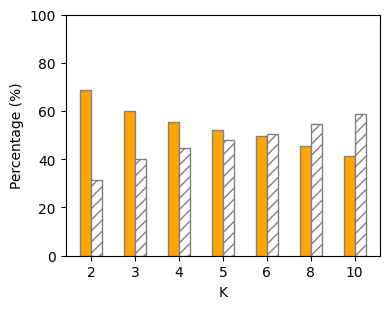

In [151]:
# === Plot ===
x = np.arange(len(k_values))
width = 0.25  # Narrower bars

plt.figure(figsize=(4, 3.2), dpi=100)
plt.bar(x - width/2, explorer_pcts, width, label='Explorers',
        color='orange', edgecolor='gray')
plt.bar(x + width/2, returner_pcts, width, label='Returners',
        color='white', edgecolor='gray', hatch='///')

plt.xticks(x, k_values)
plt.xlabel("K")
plt.ylabel("Percentage (%)")
#plt.title("Emergency period")
#plt.legend()
plt.ylim(0, 100)  # Set y-axis limit to be from 0% to 100%

plt.grid(False)
plt.tight_layout()
plt.show()


The following code generates a plot of the maximum distance from home.

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

k = 4  # Top-k time-weighted locations

# --- Step 1: Max distance from home ---
df = df_2_usual_explorerer.copy()
df['dist_from_home'] = np.sqrt((df['x'] - df['x_h'])**2 + (df['y'] - df['y_h'])**2) * 0.5  # km
max_dist = df.groupby('uid')['dist_from_home'].max().reset_index(name='max_dist')

# --- Step 2: Classify users ---
def compute_rk(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

rk_dict = compute_rk(df, k)
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

classification = {}
for uid in max_dist['uid']:
    if uid in rk_dict and uid in rg_dict and rg_dict[uid] > 0:
        sk = rk_dict[uid] / rg_dict[uid]
        classification[uid] = 'returner' if sk > 0.5 else 'explorer'
    else:
        classification[uid] = np.nan

max_dist['class'] = max_dist['uid'].map(classification)
max_dist = max_dist.dropna()

# --- Step 3: Binning ---
bin_width = 5
bins = np.arange(0, 130, bin_width)
bin_centers = bins[:-1] + bin_width / 2
max_dist['bin'] = pd.cut(max_dist['max_dist'], bins=bins, labels=bin_centers, right=False)

# --- Step 4: Aggregate ---
group_counts = max_dist.groupby(['bin', 'class']).size().unstack(fill_value=0)
group_counts['total'] = group_counts.sum(axis=1)
total_users = len(max_dist)
group_counts['explorer_pct'] = (group_counts.get('explorer', 0) / total_users) * 100
group_counts['returner_pct'] = (group_counts.get('returner', 0) / total_users) * 100


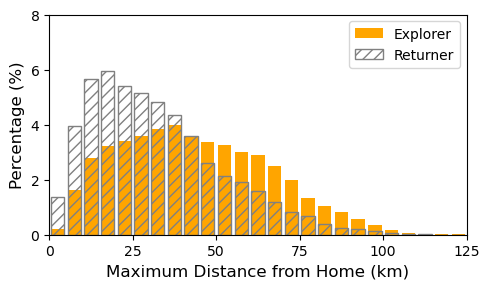

In [48]:
# --- Step 5: Plot ---
x = np.array(group_counts.index, dtype=float)
width = bin_width * 0.8  # slight space between bars

plt.figure(figsize=(5, 3), dpi=100)
plt.bar(x, group_counts['explorer_pct'], width=width, color='orange', label='Explorer')
plt.bar(x, group_counts['returner_pct'], width=width, facecolor='none', edgecolor='gray', hatch='///', label='Returner')

plt.xticks(np.arange(0, 151, 25))  # Ticks up to 150
plt.xlim(0, 125)  # Ensure plot extends to 150 km
plt.ylim(0, 8)
plt.xlabel("Maximum Distance from Home (km)", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
#plt.title("Normal period", fontsize=12)
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

The following code generates the Mann-Whitney U test results comparing the maximum distance from home distributions.

In [42]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

# Assuming 'max_dist' DataFrame contains 'class' and 'max_dist' columns

# Separate the data for returners and explorers
returners = max_dist[max_dist['class'] == 'returner']['max_dist']
explorers = max_dist[max_dist['class'] == 'explorer']['max_dist']

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(returners, explorers)

# Print results
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation of the p-value
if p_value < 0.01:
    significance = '**'  # Significant at 0.01 level
elif p_value < 0.05:
    significance = '*'   # Significant at 0.05 level
else:
    significance = 'NS'  # Not significant

print(f"Significance: {significance}")


Statistic: 52449642.0
P-value: 0.0
Significance: **


The following code generates the Kolmogorov-Smirnov test results comparing the maximum distance from home distributions.

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

# Assuming 'max_dist' DataFrame contains 'class' and 'max_dist' columns

# Separate the data for returners and explorers
returners = max_dist[max_dist['class'] == 'returner']['max_dist']
explorers = max_dist[max_dist['class'] == 'explorer']['max_dist']

# Perform Mann-Whitney U test
stat, p_value = ks_2samp(returners, explorers)

# Print results
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation of the p-value
if p_value < 0.01:
    significance = '**'  # Significant at 0.01 level
elif p_value < 0.05:
    significance = '*'   # Significant at 0.05 level
else:
    significance = 'NS'  # Not significant

print(f"Significance: {significance}")


Statistic: 0.22848799319804597
P-value: 7.119316841743363e-283
Significance: **


The following code produces the max diatance from home plots for each single day of the period.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Define a function to calculate and classify ---
def compute_rk(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

# --- Step 2: Classify users once using full dataset ---
# Use df_2_usual_explorerer or whatever your full dataset is called
rk_dict = compute_rk(df_2_usual_explorerer, k=4)
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

classification = {}
for uid in df_2_usual_explorerer['uid'].unique():
    if uid in rk_dict and uid in rg_dict and rg_dict[uid] > 0:
        sk = rk_dict[uid] / rg_dict[uid]
        classification[uid] = 'returner' if sk > 0.5 else 'explorer'
    else:
        classification[uid] = np.nan

# --- Step 3: Loop over the days and generate plots ---
for day in range(43, 58):  # Loop from 60 to 74
    # Filter df_2_usual_explorerer based on the current day
    filtered_df = df_2_usual_explorerer[df_2_usual_explorerer['d'] == day]
    
    # --- Step 4: Max distance from home ---
    df = filtered_df.copy()
    df['dist_from_home'] = np.sqrt((df['x'] - df['x_h'])**2 + (df['y'] - df['y_h'])**2) * 0.5  # km
    max_dist = df.groupby('uid')['dist_from_home'].max().reset_index(name='max_dist')

    # --- Step 5: Assign precomputed class labels ---
    max_dist['class'] = max_dist['uid'].map(classification)
    max_dist = max_dist.dropna()

    # --- Step 6: Binning ---
    bin_width = 5
    bins = np.arange(0, 130, bin_width)
    bin_centers = bins[:-1] + bin_width / 2
    max_dist['bin'] = pd.cut(max_dist['max_dist'], bins=bins, labels=bin_centers, right=False)

    # --- Step 7: Aggregate ---
    group_counts = max_dist.groupby(['bin', 'class']).size().unstack(fill_value=0)
    group_counts['total'] = group_counts.sum(axis=1)
    total_users = len(max_dist)
    group_counts['explorer_pct'] = (group_counts.get('explorer', 0) / total_users) * 100
    group_counts['returner_pct'] = (group_counts.get('returner', 0) / total_users) * 100

    # --- Step 8: Plot ---
    x = np.array(group_counts.index, dtype=float)
    width = bin_width * 0.8  # slight space between bars

    plt.figure(figsize=(5, 3), dpi=100)
    plt.bar(x, group_counts['explorer_pct'], width=width, color='orange', label='Explorer')
    plt.bar(x, group_counts['returner_pct'], width=width, facecolor='none', edgecolor='gray', hatch='///', label='Returner')

    plt.xticks(np.arange(0, 151, 25))
    plt.xlim(0, 125)
    plt.ylim(0, 35)
    plt.xlabel("Maximum Distance from Home (km)", fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)
    #plt.legend()
    plt.grid(False)
    plt.tight_layout()

    # Save the plot with appropriate filename
    plt.savefig(f"maxDistHome_usual_day{day - 42}.png", dpi=300, bbox_inches="tight")
    plt.close()


The following code produces the non-home dwelling plot. 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

k = 4  # Top-k time-weighted locations

# --- Step 1: Sum time spent away from home ---
df = df_2_usual_explorerer.copy()
df['time_away_from_home'] = np.where((df['x'] != df['x_h']) | (df['y'] != df['y_h']), df['time_spent'], 0)
time_away = df.groupby('uid')['time_away_from_home'].sum().reset_index(name='time_away_from_home')

# --- Step 2: Classify users ---
def compute_rk(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

rk_dict = compute_rk(df, k)
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

classification = {}
for uid in time_away['uid']:
    if uid in rk_dict and uid in rg_dict and rg_dict[uid] > 0:
        sk = rk_dict[uid] / rg_dict[uid]
        classification[uid] = 'returner' if sk > 0.5 else 'explorer'
    else:
        classification[uid] = np.nan

time_away['class'] = time_away['uid'].map(classification)
time_away = time_away.dropna()

# --- Step 3: Automatically create bins based on the data ---
# Use pandas to create bins based on the data distribution
bin_width = time_away['time_away_from_home'].max() / 30  # Approximate bin width to cover the range
bins = np.arange(0, time_away['time_away_from_home'].max() + bin_width, bin_width)
bin_centers = bins[:-1] + bin_width / 2
time_away['bin'] = pd.cut(time_away['time_away_from_home'], bins=bins, labels=bin_centers, right=False)

# --- Step 4: Aggregate ---
group_counts = time_away.groupby(['bin', 'class']).size().unstack(fill_value=0)
group_counts['total'] = group_counts.sum(axis=1)
total_users = len(time_away)
group_counts['explorer_pct'] = (group_counts.get('explorer', 0) / total_users) * 100
group_counts['returner_pct'] = (group_counts.get('returner', 0) / total_users) * 100



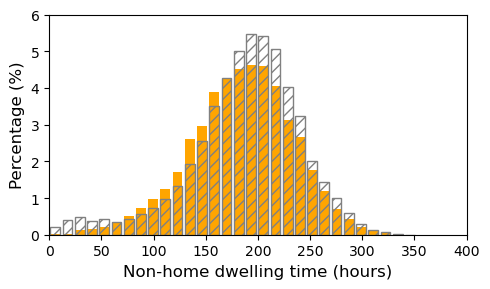

In [8]:
# --- Step 5: Plot ---
x = np.array(group_counts.index, dtype=float)
width = bin_width * 0.8  # slight space between bars

plt.figure(figsize=(5, 3), dpi=100)
plt.bar(x, group_counts['explorer_pct'], width=width, color='orange', label='Explorer')
plt.bar(x, group_counts['returner_pct'], width=width, facecolor='none', edgecolor='gray', hatch='///', label='Returner')

plt.xlabel("Non-home dwelling time (hours)", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
#plt.title("Distribution by Time Spent Away from Home (k=4)", fontsize=12)
#plt.legend()
plt.ylim(0, 6)  # Set y-axis limit to be from 0% to 100%
plt.xlim(0, 400)
plt.grid(False)
plt.tight_layout()
plt.savefig("nonHomeDwel_usual.png", dpi=300, bbox_inches="tight")

plt.show()

The following code generates the Mann-Whitney U test results comparing the non-home dwelling distributions.

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

# Assuming you already have the 'time_away' DataFrame with 'class' and 'time_away_from_home'

# Separate the data for returners and explorers
returners = time_away[time_away['class'] == 'returner']['time_away_from_home']
explorers = time_away[time_away['class'] == 'explorer']['time_away_from_home']

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(returners, explorers)

# Print results
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation of the p-value
if p_value < 0.01:
    significance = '**'  # Significant at 0.01 level
elif p_value < 0.05:
    significance = '*'   # Significant at 0.05 level
else:
    significance = 'NS'  # Not significant

print(f"Significance: {significance}")


Statistic: 82775285.5
P-value: 2.187955775824668e-36
Significance: **


The following code generates the Kolmogorov-Smirnov test results comparing the non-home dwelling distributions.

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

# Assuming you already have the 'time_away' DataFrame with 'class' and 'time_away_from_home'

# Separate the data for returners and explorers
returners = time_away[time_away['class'] == 'returner']['time_away_from_home']
explorers = time_away[time_away['class'] == 'explorer']['time_away_from_home']

# Perform Mann-Whitney U test
stat, p_value = ks_2samp(returners, explorers)

# Print results
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation of the p-value
if p_value < 0.01:
    significance = '**'  # Significant at 0.01 level
elif p_value < 0.05:
    significance = '*'   # Significant at 0.05 level
else:
    significance = 'NS'  # Not significant

print(f"Significance: {significance}")


Statistic: 0.05966979014618157
P-value: 1.7155333702070418e-19
Significance: **


The following code produces the non-home dwelling plots for each single day of the period.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Define a function to calculate rk ---
def compute_rk(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

# --- Step 2: Pre-compute classification using the full dataset ---
rk_dict_full = compute_rk(df_2_usual_explorerer, k=4)
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

classification_full = {}
for uid in df_2_usual_explorerer['uid'].unique():
    if uid in rk_dict_full and uid in rg_dict and rg_dict[uid] > 0:
        sk = rk_dict_full[uid] / rg_dict[uid]
        classification_full[uid] = 'returner' if sk > 0.5 else 'explorer'
    else:
        classification_full[uid] = np.nan

# --- Step 3: Loop over the days and generate plots ---
for day in range(43, 58):
    filtered_df = df_2_usual_explorerer[df_2_usual_explorerer['d'] == day].copy()
    
    # Time spent away from home
    filtered_df['time_away_from_home'] = np.where(
        (filtered_df['x'] != filtered_df['x_h']) | (filtered_df['y'] != filtered_df['y_h']),
        filtered_df['time_spent'],
        0
    )
    time_away = filtered_df.groupby('uid')['time_away_from_home'].sum().reset_index(name='time_away_from_home')
    
    # Map classification
    time_away['class'] = time_away['uid'].map(classification_full)
    time_away = time_away.dropna()
    
    # Binning
    bin_width = 1
    bins = np.arange(0, 25, bin_width)
    bin_centers = bins[:-1] + bin_width / 2
    time_away['bin'] = pd.cut(time_away['time_away_from_home'], bins=bins, labels=bin_centers, right=False)
    
    # Aggregation
    group_counts = time_away.groupby(['bin', 'class']).size().unstack(fill_value=0)
    group_counts['total'] = group_counts.sum(axis=1)
    total_users = len(time_away)
    group_counts['explorer_pct'] = (group_counts.get('explorer', 0) / total_users) * 100
    group_counts['returner_pct'] = (group_counts.get('returner', 0) / total_users) * 100

    # Plotting
    x = np.array(group_counts.index, dtype=float)
    width = bin_width * 0.8

    plt.figure(figsize=(5, 3), dpi=100)
    plt.bar(x, group_counts['explorer_pct'], width=width, color='orange', label='Explorer')
    plt.bar(x, group_counts['returner_pct'], width=width, facecolor='none', edgecolor='gray', hatch='///', label='Returner')

    plt.xlim(0, 24)
    plt.ylim(0, 8)
    plt.xlabel("Non-home dwelling time (hours)", fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)
    #plt.legend()
    plt.grid(False)
    plt.tight_layout()

    plt.savefig(f"nonHomeDwel_usual_day{day - 42}.png", dpi=300, bbox_inches="tight")
    plt.close()


# Entropy

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter  # Import Counter

# Example data: Assuming df_2_usual_explorerer contains 'uid', 'x', 'y', 'time_spent', and 'class' columns.
# Replace this with your actual data loading
# df_2_usual_explorerer = ...

# === Step 1: Calculate real entropy for each user ===
def calculate_real_entropy(group, window_size=2):
    """
    Calculate real entropy for each user based on time-ordered subsequences of visited locations.
    
    Parameters:
    group (DataFrame): User's trajectory data with columns ['x', 'y', 'time_spent']
    window_size (int): Size of the subsequence to consider
    
    Returns:
    float: Real entropy for the user
    """
    trajectory = list(zip(group['x'], group['y']))  # Create the sequence of visited locations
    
    # Generate subsequences of the given window size
    subsequences = [tuple(trajectory[i:i+window_size]) for i in range(len(trajectory) - window_size + 1)]
    
    # Calculate the frequency of each subsequence
    subseq_counts = Counter(subsequences)
    
    # Calculate the probabilities of each subsequence
    total_subsequences = sum(subseq_counts.values())
    probabilities = np.array([count / total_subsequences for count in subseq_counts.values()])
    
    # Calculate entropy: -sum(P * log2(P))
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy

# === Step 2: Compute r_k for users ===
def compute_rk(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500  # Convert to meters
        rk_dict[uid] = rk
    return rk_dict

# === Step 3: Classify users into returners and explorers based on r_k and radius_of_gyration ===
# Assuming 'radius_of_gyration' is already computed in 'df_2_usual_results' (e.g., from previous steps)

# --- Compute r_k for users ---
k = 4  # Top-k time-weighted locations
rk_dict = compute_rk(df_2_usual_explorerer, k)

# Assuming 'df_2_usual_results' has the radius of gyration values
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

# Classify users as 'returners' and 'explorers' based on the ratio of r_k to radius_of_gyration
classification = {}
for uid in df_2_usual_explorerer['uid']:
    if uid in rk_dict and uid in rg_dict and rg_dict[uid] > 0:
        sk = rk_dict[uid] / rg_dict[uid]
        classification[uid] = 'returner' if sk > 0.5 else 'explorer'
    else:
        classification[uid] = np.nan

df_2_usual_explorerer['class'] = df_2_usual_explorerer['uid'].map(classification)

# === Step 4: Calculate real entropy for each user ===
entropy_dict = df_2_usual_explorerer.groupby('uid').apply(calculate_real_entropy).to_dict()
df_2_usual_explorerer['real_entropy'] = df_2_usual_explorerer['uid'].map(entropy_dict)

# === Step 5: Separate returners and explorers ===
returners = df_2_usual_explorerer[df_2_usual_explorerer['class'] == 'returner']['real_entropy']
explorers = df_2_usual_explorerer[df_2_usual_explorerer['class'] == 'explorer']['real_entropy']


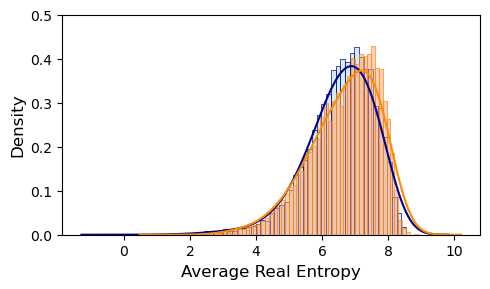

In [20]:
# === Step 6: Plotting the KDE for real entropy with bars and smoother curves ===
plt.figure(figsize=(5, 3))

# Plot bars for returners (light blue, transparent with darker border, narrow border)
sns.histplot(returners, kde=False, color='lightblue', label='Returners', bins=60, stat='density', alpha=0.5, edgecolor='darkblue', linewidth=0.5)

# Plot bars for explorers (light orange, transparent with darker border, narrow border)
sns.histplot(explorers, kde=False, color='lightsalmon', label='Explorers', bins=60, stat='density', alpha=0.5, edgecolor='darkorange', linewidth=0.5)

# KDE plot for returners (same color as bars, light blue, narrow and darker) with legend=False
sns.kdeplot(returners, color='darkblue', linewidth=1.5, bw_adjust=8, legend=False)

# KDE plot for explorers (same color as bars, light orange, narrow and darker) with legend=False
sns.kdeplot(explorers, color='darkorange', linewidth=1.5, bw_adjust=8, legend=False)

# Axis labels and title
plt.xlabel('Average Real Entropy', fontsize=12)
plt.ylabel('Density', fontsize=12)
#plt.title('Density Distribution of Average Real Entropy', fontsize=14)

# Set y-axis ticks to show every 0.1 interval, dynamically based on the range
plt.yticks(np.arange(0,0.6, 0.1))

# Add legend for bars only
#plt.legend()

# Show plot
plt.tight_layout()
plt.show()


The following code generates the Mann-Whitney U test results comparing the entropy distributions.

In [25]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

# Assuming the 'real_entropy' column exists in df_2_usual_explorerer and 'class' is available
# Separate the data for returners and explorers based on the class column
returners = df_2_usual_explorerer[df_2_usual_explorerer['class'] == 'returner']['real_entropy']
explorers = df_2_usual_explorerer[df_2_usual_explorerer['class'] == 'explorer']['real_entropy']

# Perform Mann-Whitney U Test to check for significant difference in real entropy
stat, p_value = mannwhitneyu(returners, explorers)

# Print the results of the test
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation of the p-value
if p_value < 0.01:
    significance = '**'  # Significant at the 0.01 level
elif p_value < 0.05:
    significance = '*'   # Significant at the 0.05 level
else:
    significance = 'NS'  # Not significant

print(f"Significance: {significance}")


Statistic: 4368825275187.5
P-value: 0.0
Significance: **


The following code generates the Kolmogorov-Smirnov test results comparing the entropy distributions.

In [10]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

# Assuming the 'real_entropy' column exists in df_2_usual_explorerer and 'class' is available
# Separate the data for returners and explorers based on the class column
returners = df_2_usual_explorerer[df_2_usual_explorerer['class'] == 'returner']['real_entropy']
explorers = df_2_usual_explorerer[df_2_usual_explorerer['class'] == 'explorer']['real_entropy']

# Perform Mann-Whitney U Test to check for significant difference in real entropy
stat, p_value = ks_2samp(returners, explorers)

# Print the results of the test
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation of the p-value
if p_value < 0.01:
    significance = '**'  # Significant at the 0.01 level
elif p_value < 0.05:
    significance = '*'   # Significant at the 0.05 level
else:
    significance = 'NS'  # Not significant

print(f"Significance: {significance}")


Statistic: 0.06828817106822249
P-value: 0.0
Significance: **


# Transitions

In [16]:
import pandas as pd

# Assuming 'df_2_usual_explorerer' contains the user data and 'class' column has already been created
# If not, we can classify the users as 'returner' or 'explorer' using the following approach:

# --- Compute r_k for users ---
k = 4  # Top-k time-weighted locations
rk_dict = compute_rk(df_2_usual_explorerer, k)

# Assuming 'df_2_usual_results' has the radius of gyration values
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

# Classify users as 'returners' and 'explorers' based on the ratio of r_k to radius_of_gyration
classification = {}
for uid in df_2_usual_explorerer['uid']:
    if uid in rk_dict and uid in rg_dict and rg_dict[uid] > 0:
        sk = rk_dict[uid] / rg_dict[uid]
        classification[uid] = 'returner' if sk > 0.5 else 'explorer'
    else:
        classification[uid] = np.nan

# Add classification as a new column
df_2_usual_explorerer['class'] = df_2_usual_explorerer['uid'].map(classification)

# Create a new DataFrame with UID, Returner, and Explorer columns
classification_df = pd.DataFrame({
    'UID': df_2_usual_explorerer['uid'],
    'Returner': df_2_usual_explorerer['class'].apply(lambda x: 1 if x == 'returner' else 0),
    'Explorer': df_2_usual_explorerer['class'].apply(lambda x: 1 if x == 'explorer' else 0)
})

# Save the DataFrame to a CSV file
classification_df.to_csv('user_classification_usual.csv', index=False)

print("CSV file 'user_classification_usual.csv' has been saved successfully.")


CSV file 'user_classification_usual.csv' has been saved successfully.


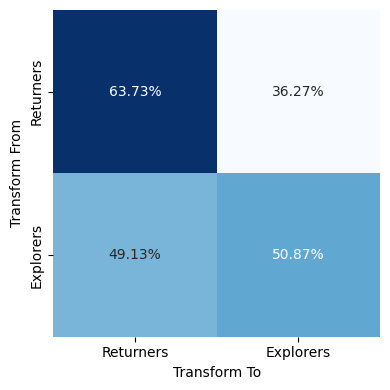

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the two classification CSV files
df_emerg = pd.read_csv('user_classification_emerg.csv')
df_usual = pd.read_csv('user_classification_usual.csv')

# Define chunk size (process data in chunks)
chunk_size = 5000  # Process 5000 UIDs at a time

# Initialize an empty list to store results
transition_data = []

# Process data in chunks
for start in range(0, len(df_usual), chunk_size):
    end = start + chunk_size
    df_usual_chunk = df_usual.iloc[start:end]
    df_emerg_chunk = df_emerg.iloc[start:end]
    
    # Merge the two DataFrames on 'UID' to compare the classifications
    df_chunk = pd.merge(df_usual_chunk, df_emerg_chunk, on='UID', suffixes=('_usual', '_emerg'))
    
    # Ensure there are no missing values in the classifications
    df_chunk.dropna(subset=['Returner_usual', 'Explorer_usual', 'Returner_emerg', 'Explorer_emerg'], inplace=True)
    
    # Create a new column 'transition' to track the transitions
    df_chunk['transition'] = np.nan
    
    # Assign transitions based on the classification
    df_chunk.loc[(df_chunk['Returner_usual'] == 1) & (df_chunk['Returner_emerg'] == 1), 'transition'] = 'Returner -> Returner'
    df_chunk.loc[(df_chunk['Returner_usual'] == 1) & (df_chunk['Explorer_emerg'] == 1), 'transition'] = 'Returner -> Explorer'
    df_chunk.loc[(df_chunk['Explorer_usual'] == 1) & (df_chunk['Returner_emerg'] == 1), 'transition'] = 'Explorer -> Returner'
    df_chunk.loc[(df_chunk['Explorer_usual'] == 1) & (df_chunk['Explorer_emerg'] == 1), 'transition'] = 'Explorer -> Explorer'
    
    # Append the transition data for this chunk
    transition_data.append(df_chunk['transition'])

# Combine the data from all chunks
transition_data_combined = pd.concat(transition_data)

# Calculate the count of each transition type
transition_counts = transition_data_combined.value_counts()

# Initialize the transition matrix with zeros
matrix = np.zeros((2, 2))

# Populate the transition matrix with transition counts
matrix[0, 0] = transition_counts.get('Returner -> Returner', 0)
matrix[0, 1] = transition_counts.get('Returner -> Explorer', 0)
matrix[1, 0] = transition_counts.get('Explorer -> Returner', 0)
matrix[1, 1] = transition_counts.get('Explorer -> Explorer', 0)

# Normalize each row to ensure it sums to 100%
matrix[0, :] = matrix[0, :] / matrix[0, :].sum() * 100  # Normalize for Returner row
matrix[1, :] = matrix[1, :] / matrix[1, :].sum() * 100  # Normalize for Explorer row

# Plotting the transition matrix as a heatmap (without color bar)
plt.figure(figsize=(4, 4))
sns.heatmap(matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Returners', 'Explorers'], yticklabels=['Returners', 'Explorers'], cbar=False)

# Customizing the annotations to add percentage sign
for text in plt.gca().texts:
    text.set_text(f"{text.get_text()}%")

# Titles and labels
plt.xlabel('Transform To')
plt.ylabel('Transform From')

# Show plot
plt.tight_layout()
#plt.savefig("transform.png", dpi=300, bbox_inches="tight")
plt.show()


In [1]:
import pandas as pd
import numpy as np

# Load the classification data
df_emerg = pd.read_csv('user_classification_emerg.csv')  # Emergency classification data
df_usual = pd.read_csv('user_classification_usual.csv')  # Usual classification data

# Step 1: Remove duplicate rows for each UID
df_emerg_unique = df_emerg.drop_duplicates(subset=['UID'])
df_usual_unique = df_usual.drop_duplicates(subset=['UID'])

# Step 2: Merge usual and emergency classifications on UID
df_combined = pd.merge(
    df_usual_unique[['UID', 'Returner']], 
    df_emerg_unique[['UID', 'Returner']], 
    on='UID', 
    suffixes=('_usual', '_emerg')
)

# Step 3: Classify UIDs based on Returner status in both conditions
def classify_group(row):
    # Case 1: Returner in both usual and emergency
    if row['Returner_usual'] == 1 and row['Returner_emerg'] == 1:
        return 1
    # Case 2: Returner in usual but not in emergency
    elif row['Returner_usual'] == 1 and row['Returner_emerg'] == 0:
        return 2
    # Case 3: Not Returner in usual, but Returner in emergency
    elif row['Returner_usual'] == 0 and row['Returner_emerg'] == 1:
        return 4
    # Case 4: Not Returner in either
    elif row['Returner_usual'] == 0 and row['Returner_emerg'] == 0:
        return 3
    else:
        return np.nan

df_combined['reclass'] = df_combined.apply(classify_group, axis=1)

# Step 4: Load emergency days data
df_15emergencyDays = pd.read_parquet("/work/wissamkontar/omida/YJMob100K/Code/df_2_usual_explorerer.parquet")

# Step 5: Merge classification back to emergency days data
df_merged = pd.merge(
    df_15emergencyDays,
    df_combined[['UID', 'reclass']],
    left_on='uid',
    right_on='UID',
    how='left'
).drop(columns=['UID'])  # Drop the extra UID column

# Save or use the merged data
print(df_merged.head())

   uid   d   t   x   y  day_of_week  holiday  weekend   x_h   y_h  ...  \
0    1  43  13  77  86            2        0        0  77.0  86.0  ...   
1    1  43  14  85  96            2        0        0  77.0  86.0  ...   
2    1  43  15  87  95            2        0        0  77.0  86.0  ...   
3    1  43  16  85  94            2        0        0  77.0  86.0  ...   
4    1  43  17  82  91            2        0        0  77.0  86.0  ...   

   time_spent      dist  walk_d_home  walk_d_work  out_home_trip  \
0         0.5  0.000000            1            0              0   
1         0.5  6.403124            0            1              1   
2         0.5  1.118034            0            1              0   
3         0.5  1.118034            0            1              0   
4         0.5  2.121320            0            0              0   

   out_work_trip  xy_h_location  xy_location  reclass_x  reclass_y  
0              0        15286.0        15286          4          4  
1       

In [1]:
#df_merged.to_parquet("/work/wissamkontar/omida/YJMob100K/Code/df_2_usual_explorerer.parquet", engine="pyarrow", index=False)


In [11]:
import pandas as pd

# 1. First get unique x,y pairs for each user and calculate their average poi_sum
unique_poi_per_user = (df_merged.drop_duplicates(['uid', 'x', 'y'])
                       .groupby(['uid', 'reclass'])['poi_sum']
                       .mean()
                       .reset_index())

# 2. Then calculate average across users within each reclass group
avg_poi_by_reclass = (unique_poi_per_user.groupby('reclass')['poi_sum']
                      .mean()
                      .reset_index())
avg_poi_by_reclass.columns = ['reclass', 'avg_poi_sum_per_unique_location']

# Display results
print(avg_poi_by_reclass)

   reclass  avg_poi_sum_per_unique_location
0        1                        85.254188
1        2                        77.983283
2        3                        76.044674
3        4                        79.858515


In [ ]:
import pandas as pd

# Step 1: Filter for home locations
home_df = df_merged[(df_merged['walk_d_home'] == 0) & (df_merged['holiday'] == 1)]

# Step 2: Calculate total time spent at home per UID
uid_home_time = home_df.groupby(['uid'])['poi_sum'].mean().reset_index()
uid_home_time.columns = ['uid', 'total_time_at_home']

# Step 3: Get UID and their corresponding reclass values
uid_reclass = df_merged[['uid', 'reclass']].drop_duplicates(subset='uid')

# Step 4: Merge time and reclass
merged = pd.merge(uid_home_time, uid_reclass, on='uid', how='inner')

# Step 5: Compute average total time at home per reclass group
result = merged.groupby('reclass')['total_time_at_home'].mean().reset_index()
result.columns = ['reclass', 'avg_total_time_at_home']

# Display result
print(result)


   reclass  avg_total_time_at_home
0        1               95.286977
1        2               88.619929
2        3               87.391937
3        4               89.157808


In [39]:
import pandas as pd

# Step 1: Filter for home locations
home_df = df_merged[(df_merged['walk_d_home'] == 0) & (df_merged['holiday'] == 0)]

# Step 2: Calculate total time spent at home per UID
uid_home_time = home_df.groupby(['uid'])['poi_sum'].mean().reset_index()
uid_home_time.columns = ['uid', 'total_time_at_home']

# Step 3: Get UID and their corresponding reclass values
uid_reclass = df_merged[['uid', 'reclass']].drop_duplicates(subset='uid')

# Step 4: Merge time and reclass
merged = pd.merge(uid_home_time, uid_reclass, on='uid', how='inner')

# Step 5: Compute average total time at home per reclass group
result = merged.groupby('reclass')['total_time_at_home'].mean().reset_index()
result.columns = ['reclass', 'avg_total_time_at_home']

# Display result
print(result)


   reclass  avg_total_time_at_home
0        1              108.033640
1        2               92.193574
2        3               85.643842
3        4               90.308531


In [42]:
import pandas as pd

# Step 1: Filter for home locations
home_df = df_merged[(df_merged['walk_d_home'] == 1)]

# Step 2: Calculate total time spent at home per UID
uid_home_time = home_df.groupby(['uid'])['poi_sum'].mean().reset_index()
uid_home_time.columns = ['uid', 'total_time_at_home']

# Step 3: Get UID and their corresponding reclass values
uid_reclass = df_merged[['uid', 'reclass']].drop_duplicates(subset='uid')

# Step 4: Merge time and reclass
merged = pd.merge(uid_home_time, uid_reclass, on='uid', how='inner')

# Step 5: Compute average total time at home per reclass group
result = merged.groupby('reclass')['total_time_at_home'].mean().reset_index()
result.columns = ['reclass', 'avg_total_time_at_home']

# Display result
print(result)


   reclass  avg_total_time_at_home
0        1               61.017690
1        2               60.498692
2        3               61.084704
3        4               60.922939


# Spatial distributon

The following code generates the plot for average number of stops for explorers.

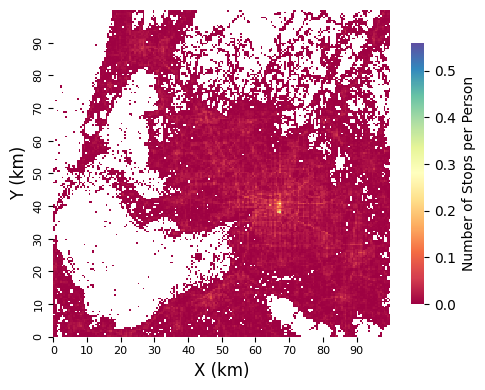

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the two classification CSV files
df_classification_emerg = pd.read_csv('user_classification_usual.csv')  # User classification data

# Step 1: Filter df_2_usual_explorerer based on returners from df_classification_emerg
# Select users that are returners (Returner == 1)
returners = df_classification_emerg[df_classification_emerg['Returner'] == 0]['UID']

# Filter the df_2_usual_explorerer dataset for these returners
df_returners = df_2_usual_explorerer[df_2_usual_explorerer['uid'].isin(returners)]

# Step 2: Calculate the number of recordings for each (x, y) per person (per user)
# Group by 'uid', 'x', 'y' and count the number of occurrences for each combination
user_recordings = df_returners.groupby(['uid', 'x', 'y']).size().reset_index(name='recordings')

# Step 3: Calculate the total number of recordings per location (sum across users for each (x, y))
# Calculate the total number of unique returners
num_returners = df_returners['uid'].nunique()

# Normalize the recordings by dividing by the total number of returners
total_recordings_per_location = user_recordings.groupby(['x', 'y'])['recordings'].sum().reset_index()

# Normalize by dividing by the number of returners
total_recordings_per_location['recordings'] = total_recordings_per_location['recordings'] / num_returners

# Step 4: Create a grid for the heatmap
# Pivot the data to create a 2D grid (matrix) for the heatmap
heatmap_data = total_recordings_per_location.pivot(index='y', columns='x', values='recordings')

# Step 5: Create real-world tick labels in kilometers
x_km_labels = np.array(heatmap_data.columns) * 0.5  # Convert to kilometers
y_km_labels = np.array(heatmap_data.index) * 0.5  # Convert to kilometers

# Step 6: Plot the heatmap with thinner color bar
plt.figure(figsize=(5, 4))
sns.heatmap(
    heatmap_data,
    cmap="Spectral",
    cbar_kws={'label': 'Number of Stops per Person', 'shrink': 0.8, 'ticks': np.arange(0, 1.1, 0.1)},  # Adjust color bar ticks
    vmin=0,
    vmax=0.56,  # Automatically adjust the maximum value based on data
    xticklabels=20,  # Show tick labels every 20 intervals on x-axis
    yticklabels=20   # Show tick labels every 20 intervals on y-axis
)

# Update axis ticks
ax = plt.gca()
ax.set_xticks(np.linspace(0, len(x_km_labels)-1, len(x_km_labels))[::20])  # Set x-axis ticks every 20 intervals
ax.set_xticklabels([f'{val:.0f}' for val in x_km_labels[::20]], fontsize=8)

ax.set_yticks(np.linspace(0, len(y_km_labels)-1, len(y_km_labels))[::20])  # Set y-axis ticks every 20 intervals
ax.set_yticklabels([f'{val:.0f}' for val in y_km_labels[::20]], fontsize=8)

# Axis labels and title
plt.xlabel('X (km)', fontsize=12)
plt.ylabel('Y (km)', fontsize=12)
#plt.title('Average Number of Activity Stops per Person for Returners', fontsize=14)

# Invert y-axis to start from 0 km at bottom
ax.invert_yaxis()

# Show plot
plt.tight_layout()
plt.show()


The following code generates the plot for average stay time for returners.

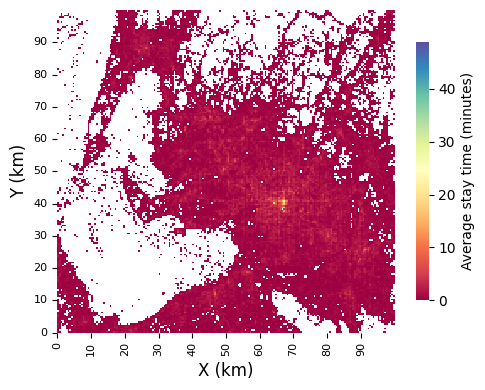

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the two classification CSV files
df_classification_emerg = pd.read_csv('user_classification_usual.csv')  # User classification data

# Step 1: Filter df_2_usual_explorerer based on returners from df_classification_emerg
# Select users that are returners (Returner == 1)
returners = df_classification_emerg[df_classification_emerg['Returner'] == 1]['UID']

# Filter the df_2_usual_explorerer dataset for these returners
df_returners = df_2_usual_explorerer[df_2_usual_explorerer['uid'].isin(returners)]

# Step 2: Calculate the total time spent for each (x, y) per person (per user)
# Group by 'uid', 'x', 'y' and sum the time spent at each location for each user
# Convert time_spent from hours to minutes
user_time_spent = df_returners.groupby(['uid', 'x', 'y'])['time_spent'].sum().reset_index(name='time_spent')
user_time_spent['time_spent'] = user_time_spent['time_spent'] * 60  # Convert to minutes

# Step 3: Calculate the total time spent per location (sum across users for each (x, y))
# Calculate the total number of unique returners
num_returners = df_returners['uid'].nunique()

# Sum the time spent for each (x, y) and normalize by the number of returners
total_time_spent_per_location = user_time_spent.groupby(['x', 'y'])['time_spent'].sum().reset_index()

# Normalize by dividing by the number of returners
total_time_spent_per_location['time_spent'] = total_time_spent_per_location['time_spent'] / num_returners

# Step 4: Create a grid for the heatmap
# Pivot the data to create a 2D grid (matrix) for the heatmap
heatmap_data = total_time_spent_per_location.pivot(index='y', columns='x', values='time_spent')

# Step 5: Create real-world tick labels in kilometers
x_km_labels = np.array(heatmap_data.columns) * 0.5  # Convert to kilometers
y_km_labels = np.array(heatmap_data.index) * 0.5  # Convert to kilometers

# Step 6: Plot the heatmap with thinner color bar
plt.figure(figsize=(5, 4))
sns.heatmap(
    heatmap_data,
    cmap="Spectral",
    cbar_kws={'label': 'Average stay time (minutes)', 'shrink': 0.8, 'ticks': np.arange(0, 150, 10)},  # Shrink the color bar to make it thinner
    vmin=0,
    vmax=heatmap_data.max().max(),  # Automatically adjust the maximum value based on data
    xticklabels=10,
    yticklabels=10
)

# Update axis ticks
ax = plt.gca()
ax.set_xticks(np.linspace(0, len(x_km_labels)-1, len(x_km_labels))[::20])  # Set x-axis ticks every 20 intervals
ax.set_xticklabels([f'{val:.0f}' for val in x_km_labels[::20]], fontsize=8)

ax.set_yticks(np.linspace(0, len(y_km_labels)-1, len(y_km_labels))[::20])  # Set y-axis ticks every 20 intervals
ax.set_yticklabels([f'{val:.0f}' for val in y_km_labels[::20]], fontsize=8)

# Axis labels and title
plt.xlabel('X (km)', fontsize=12)
plt.ylabel('Y (km)', fontsize=12)
#plt.title('Average Time Spent per Person for Returners', fontsize=14)

# Invert y-axis to start from 0 km at bottom
ax.invert_yaxis()

# Show plot
plt.tight_layout()
plt.show()


The following code generates the plot for average stay time for explorers.

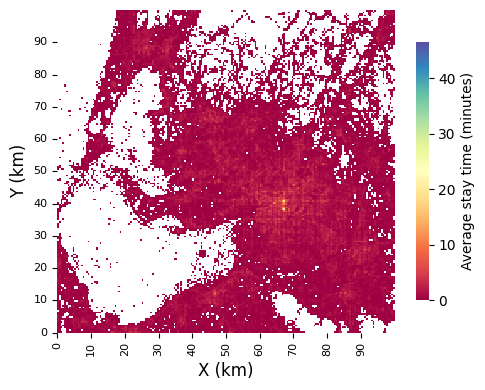

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the two classification CSV files
df_classification_emerg = pd.read_csv('user_classification_usual.csv')  # User classification data

# Step 1: Filter df_2_usual_explorerer based on returners from df_classification_emerg
# Select users that are returners (Returner == 1)
returners = df_classification_emerg[df_classification_emerg['Returner'] == 0]['UID']

# Filter the df_2_usual_explorerer dataset for these returners
df_returners = df_2_usual_explorerer[df_2_usual_explorerer['uid'].isin(returners)]

# Step 2: Calculate the total time spent for each (x, y) per person (per user)
# Group by 'uid', 'x', 'y' and sum the time spent at each location for each user
# Convert time_spent from hours to minutes
user_time_spent = df_returners.groupby(['uid', 'x', 'y'])['time_spent'].sum().reset_index(name='time_spent')
user_time_spent['time_spent'] = user_time_spent['time_spent'] * 60  # Convert to minutes

# Step 3: Calculate the total time spent per location (sum across users for each (x, y))
# Calculate the total number of unique returners
num_returners = df_returners['uid'].nunique()

# Sum the time spent for each (x, y) and normalize by the number of returners
total_time_spent_per_location = user_time_spent.groupby(['x', 'y'])['time_spent'].sum().reset_index()

# Normalize by dividing by the number of returners
total_time_spent_per_location['time_spent'] = total_time_spent_per_location['time_spent'] / num_returners

# Step 4: Create a grid for the heatmap
# Pivot the data to create a 2D grid (matrix) for the heatmap
heatmap_data = total_time_spent_per_location.pivot(index='y', columns='x', values='time_spent')

# Step 5: Create real-world tick labels in kilometers
x_km_labels = np.array(heatmap_data.columns) * 0.5  # Convert to kilometers
y_km_labels = np.array(heatmap_data.index) * 0.5  # Convert to kilometers

# Step 6: Plot the heatmap with thinner color bar
plt.figure(figsize=(5, 4))
sns.heatmap(
    heatmap_data,
    cmap="Spectral",
    cbar_kws={'label': 'Average stay time (minutes)', 'shrink': 0.8, 'ticks': np.arange(0, 150, 10)},  # Shrink the color bar to make it thinner
    vmin=0,
    vmax=46.44,  # Automatically adjust the maximum value based on data
    xticklabels=10,
    yticklabels=10
)

# Update axis ticks
ax = plt.gca()
ax.set_xticks(np.linspace(0, len(x_km_labels)-1, len(x_km_labels))[::20])  # Set x-axis ticks every 20 intervals
ax.set_xticklabels([f'{val:.0f}' for val in x_km_labels[::20]], fontsize=8)

ax.set_yticks(np.linspace(0, len(y_km_labels)-1, len(y_km_labels))[::20])  # Set y-axis ticks every 20 intervals
ax.set_yticklabels([f'{val:.0f}' for val in y_km_labels[::20]], fontsize=8)

# Axis labels and title
plt.xlabel('X (km)', fontsize=12)
plt.ylabel('Y (km)', fontsize=12)
#plt.title('Average Time Spent per Person for Returners', fontsize=14)

# Invert y-axis to start from 0 km at bottom
ax.invert_yaxis()

# Show plot
plt.tight_layout()
plt.show()


# 15 minute city

In [9]:
import numpy as np

# --- Step 2: Classify users ---
def compute_rk(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

k = 4  # Top-k time-weighted locations
rk_dict = compute_rk(df_2_usual_explorerer, k)

# Assuming 'df_2_usual_results' has the radius of gyration values
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Use precomputed classification for k=6 ===
rk_dict_k6 = compute_rk(df_2_usual_explorerer, k=6)
classification_k6 = {}

for uid in rk_dict_k6:
    if uid in rg_dict and rg_dict[uid] > 0:
        sk = rk_dict_k6[uid] / rg_dict[uid]
        classification_k6[uid] = 'returner' if sk > 0.5 else 'explorer'

The following code generates the plot for holidays.

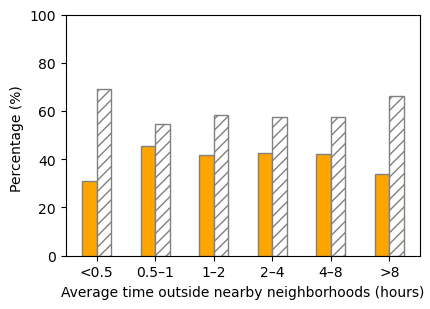

In [99]:


# === Step 2: Filter to holidays only and compute avg time outside nearby neighborhoods ===
df_holiday = df_2_usual_explorerer[
    (df_2_usual_explorerer['holiday'] == 1) & (df_2_usual_explorerer['walk_d_home'] == 0)
]

time_out_hol = df_holiday.groupby('uid')['time_spent'].sum()
unique_days_hol = df_2_usual_explorerer[df_2_usual_explorerer['holiday'] == 1].groupby('uid')['d'].nunique()
avg_out_time_hol = (time_out_hol / unique_days_hol).dropna()

# === Step 3: Merge with classification ===
classification_series = pd.Series(classification_k6)
classification_series.name = 'class'
merged_holiday = pd.concat([avg_out_time_hol, classification_series], axis=1).dropna()
merged_holiday.columns = ['avg_out_time_holiday', 'class']

# === Step 4: Bin users by holiday avg_out_time ===
bins = [0, 0.5, 1, 2, 4, 8, 24]
labels = ['<0.5h', '0.5–1h', '1–2h', '2–4h', '4–8h', '>8h']
merged_holiday['bin'] = pd.cut(merged_holiday['avg_out_time_holiday'], bins=bins, labels=labels, right=False)

# === Step 5: Count returners vs explorers in each bin ===
pivot_hol = merged_holiday.groupby(['bin', 'class']).size().unstack(fill_value=0)
pivot_hol_pct = pivot_hol.div(pivot_hol.sum(axis=1), axis=0) * 100

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the data processing and classification steps are already done
# Step 1: Use precomputed classification for k=6 and holiday time outside nearby neighborhoods
# These steps were already done before in your code

# Step 2: Generate the plot
plt.figure(figsize=(4.4, 3.2))

# Define the bar width
width = 0.25  # Narrower bars to display returners and explorers side by side

# Define the positions for the bars
x = np.arange(len(pivot_hol_pct))

# Plot 'Explorers' bars with custom styling
plt.bar(x - width/2, pivot_hol_pct['explorer'], width, label='Explorers',
        color='orange', edgecolor='gray')

# Plot 'Returners' bars with custom styling
plt.bar(x + width/2, pivot_hol_pct['returner'], width, label='Returners',
        color='white', edgecolor='gray', hatch='///')

# Add the x-ticks for the bins
# Remove 'h' from tick labels
ticks = [str(label) for label in pivot_hol_pct.index]
ticks = [label.replace('h', '') for label in ticks]  # Remove 'h' from the labels
plt.xticks(x, ticks, fontsize=10)

# Axis labels and title
plt.xlabel('Average time outside nearby neighborhoods (hours)')
plt.ylabel('Percentage (%) ')

# Set y-axis limit to be from 0 to 100
plt.ylim(0, 100)

# Add legend
#plt.legend()

# Display gridlines on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.grid(False)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()



The following code generates the plot for weeekdays.

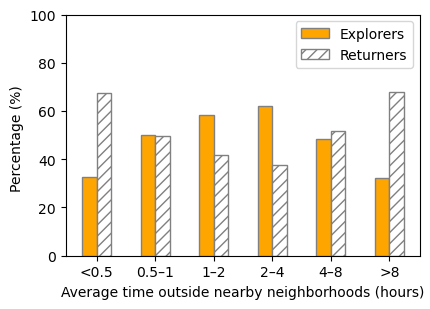

In [100]:
# === Step 2: Filter to holidays only and compute avg time outside nearby neighborhoods ===
df_holiday = df_2_usual_explorerer[
    (df_2_usual_explorerer['holiday'] == 0) & (df_2_usual_explorerer['walk_d_home'] == 0)
]

time_out_hol = df_holiday.groupby('uid')['time_spent'].sum()
unique_days_hol = df_2_usual_explorerer[df_2_usual_explorerer['holiday'] == 0].groupby('uid')['d'].nunique()
avg_out_time_hol = (time_out_hol / unique_days_hol).dropna()

# === Step 3: Merge with classification ===
classification_series = pd.Series(classification_k6)
classification_series.name = 'class'
merged_holiday = pd.concat([avg_out_time_hol, classification_series], axis=1).dropna()
merged_holiday.columns = ['avg_out_time_holiday', 'class']

# === Step 4: Bin users by holiday avg_out_time ===
bins = [0, 0.5, 1, 2, 4, 8, 24]
labels = ['<0.5h', '0.5–1h', '1–2h', '2–4h', '4–8h', '>8h']
merged_holiday['bin'] = pd.cut(merged_holiday['avg_out_time_holiday'], bins=bins, labels=labels, right=False)

# === Step 5: Count returners vs explorers in each bin ===
pivot_hol = merged_holiday.groupby(['bin', 'class']).size().unstack(fill_value=0)
pivot_hol_pct = pivot_hol.div(pivot_hol.sum(axis=1), axis=0) * 100

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the data processing and classification steps are already done
# Step 1: Use precomputed classification for k=6 and holiday time outside nearby neighborhoods
# These steps were already done before in your code

# Step 2: Generate the plot
plt.figure(figsize=(4.4, 3.2))

# Define the bar width
width = 0.25  # Narrower bars to display returners and explorers side by side

# Define the positions for the bars
x = np.arange(len(pivot_hol_pct))

plt.bar(x - width/2, pivot_hol_pct['explorer'], width, label='Explorers',
        color='orange', edgecolor='gray')

# Plot 'Returners' bars with custom styling
plt.bar(x + width/2, pivot_hol_pct['returner'], width, label='Returners',
        color='white', edgecolor='gray', hatch='///')

# Add the x-ticks for the bins
# Remove 'h' from tick labels
ticks = [str(label) for label in pivot_hol_pct.index]
ticks = [label.replace('h', '') for label in ticks]  # Remove 'h' from the labels
plt.xticks(x, ticks, fontsize=10)

# Axis labels and title
plt.xlabel('Average time outside nearby neighborhoods (hours)')
plt.ylabel('Percentage (%) ')

# Set y-axis limit to be from 0 to 100
plt.ylim(0, 100)

# Add legend
plt.legend()

# Display gridlines on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.grid(False)

# Adjust the layout
plt.tight_layout()

# Show the plot

plt.show()


The following code generates the plot for weekdays.

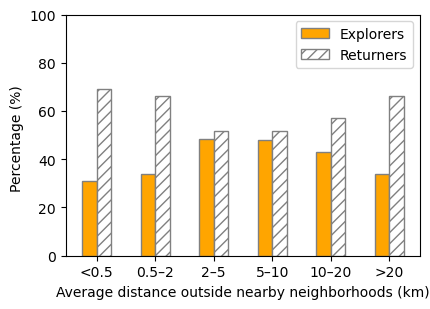

In [96]:
# === Step 2: Filter to holidays only and compute avg time outside nearby neighborhoods ===
df_holiday = df_2_usual_explorerer[
    (df_2_usual_explorerer['holiday'] == 0) & (df_2_usual_explorerer['walk_d_home'] == 0)
]

time_out_hol = df_holiday.groupby('uid')['dist'].sum()
unique_days_hol = df_2_usual_explorerer[df_2_usual_explorerer['holiday'] == 0].groupby('uid')['d'].nunique()
avg_out_time_hol = (time_out_hol / unique_days_hol).dropna()

# === Step 3: Merge with classification ===
classification_series = pd.Series(classification_k6)
classification_series.name = 'class'
merged_holiday = pd.concat([avg_out_time_hol, classification_series], axis=1).dropna()
merged_holiday.columns = ['avg_out_time_holiday', 'class']

# === Step 4: Bin users by holiday avg_out_time ===
bins = [0, 0.5, 2, 5, 10, 20, 100]
labels = ['<0.5h', '0.5–2h', '2–5h', '5–10h', '10–20h', '>20h']
merged_holiday['bin'] = pd.cut(merged_holiday['avg_out_time_holiday'], bins=bins, labels=labels, right=False)

# === Step 5: Count returners vs explorers in each bin ===
pivot_hol = merged_holiday.groupby(['bin', 'class']).size().unstack(fill_value=0)
pivot_hol_pct = pivot_hol.div(pivot_hol.sum(axis=1), axis=0) * 100

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the data processing and classification steps are already done
# Step 1: Use precomputed classification for k=6 and holiday time outside nearby neighborhoods
# These steps were already done before in your code

# Step 2: Generate the plot
plt.figure(figsize=(4.4, 3.2))

# Define the bar width
width = 0.25  # Narrower bars to display returners and explorers side by side

# Define the positions for the bars
x = np.arange(len(pivot_hol_pct))

# Plot 'Explorers' bars with custom styling
plt.bar(x - width/2, pivot_hol_pct['explorer'], width, label='Explorers',
        color='orange', edgecolor='gray')

# Plot 'Returners' bars with custom styling
plt.bar(x + width/2, pivot_hol_pct['returner'], width, label='Returners',
        color='white', edgecolor='gray', hatch='///')

# Add the x-ticks for the bins
# Remove 'h' from tick labels
ticks = [str(label) for label in pivot_hol_pct.index]
ticks = [label.replace('h', '') for label in ticks]  # Remove 'h' from the labels
plt.xticks(x, ticks, fontsize=10)

# Axis labels and title
plt.xlabel('Average distance outside nearby neighborhoods (km)')
plt.ylabel('Percentage (%) ')

# Set y-axis limit to be from 0 to 100
plt.ylim(0, 100)

# Add legend
plt.legend()

# Display gridlines on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.grid(False)

# Adjust the layout
plt.tight_layout()

# Show the plot

plt.show()


The following code generates the plot for holidays.

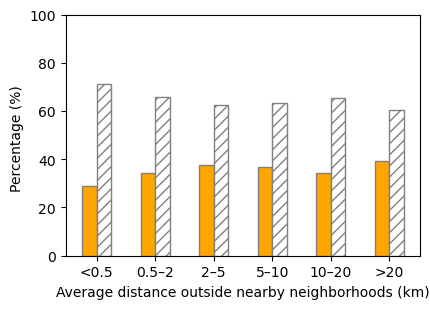

In [97]:
# === Step 2: Filter to holidays only and compute avg time outside nearby neighborhoods ===
df_holiday = df_2_usual_explorerer[
    (df_2_usual_explorerer['holiday'] == 1) & (df_2_usual_explorerer['walk_d_home'] == 0)
]

time_out_hol = df_holiday.groupby('uid')['dist'].sum()
unique_days_hol = df_2_usual_explorerer[df_2_usual_explorerer['holiday'] == 1].groupby('uid')['d'].nunique()
avg_out_time_hol = (time_out_hol / unique_days_hol).dropna()

# === Step 3: Merge with classification ===
classification_series = pd.Series(classification_k6)
classification_series.name = 'class'
merged_holiday = pd.concat([avg_out_time_hol, classification_series], axis=1).dropna()
merged_holiday.columns = ['avg_out_time_holiday', 'class']

# === Step 4: Bin users by holiday avg_out_time ===
bins = [0, 0.5, 2, 5, 10, 20, 100]
labels = ['<0.5h', '0.5–2h', '2–5h', '5–10h', '10–20h', '>20h']
merged_holiday['bin'] = pd.cut(merged_holiday['avg_out_time_holiday'], bins=bins, labels=labels, right=False)

# === Step 5: Count returners vs explorers in each bin ===
pivot_hol = merged_holiday.groupby(['bin', 'class']).size().unstack(fill_value=0)
pivot_hol_pct = pivot_hol.div(pivot_hol.sum(axis=1), axis=0) * 100

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the data processing and classification steps are already done
# Step 1: Use precomputed classification for k=6 and holiday time outside nearby neighborhoods
# These steps were already done before in your code

# Step 2: Generate the plot
plt.figure(figsize=(4.4, 3.2))

# Define the bar width
width = 0.25  # Narrower bars to display returners and explorers side by side

# Define the positions for the bars
x = np.arange(len(pivot_hol_pct))

# Plot 'Explorers' bars with custom styling
plt.bar(x - width/2, pivot_hol_pct['explorer'], width, label='Explorers',
        color='orange', edgecolor='gray')

# Plot 'Returners' bars with custom styling
plt.bar(x + width/2, pivot_hol_pct['returner'], width, label='Returners',
        color='white', edgecolor='gray', hatch='///')

# Add the x-ticks for the bins
# Remove 'h' from tick labels
ticks = [str(label) for label in pivot_hol_pct.index]
ticks = [label.replace('h', '') for label in ticks]  # Remove 'h' from the labels
plt.xticks(x, ticks, fontsize=10)

# Axis labels and title
plt.xlabel('Average distance outside nearby neighborhoods (km)')
plt.ylabel('Percentage (%) ')

# Set y-axis limit to be from 0 to 100
plt.ylim(0, 100)

# Add legend
#plt.legend()

# Display gridlines on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.grid(False)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


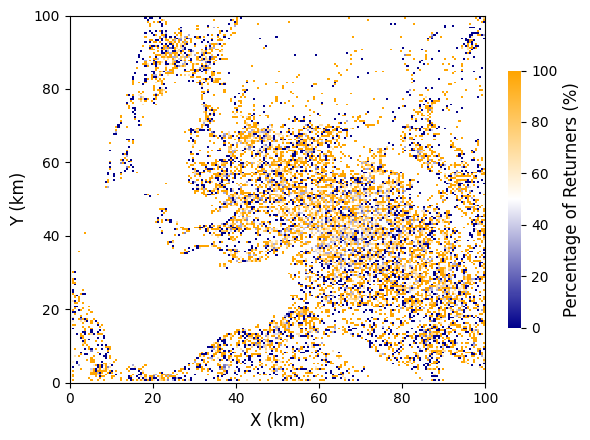

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create 200x200 grid (1 unit per cell)
grid_size = 200
x_bins = np.arange(0, 201)  # 0 to 200 (201 edges for 200 cells)
y_bins = np.arange(0, 201)

# Calculate histograms
returner_mask = spatial_df['class'] == 'returner'
returner_counts, _, _ = np.histogram2d(
    spatial_df.loc[returner_mask, 'x_h'],
    spatial_df.loc[returner_mask, 'y_h'],
    bins=[x_bins, y_bins]
)

total_counts, _, _ = np.histogram2d(
    spatial_df['x_h'],
    spatial_df['y_h'],
    bins=[x_bins, y_bins]
)

# Calculate percentage (set NaN where no data exists)
percentage_returners = np.full(returner_counts.shape, np.nan)  # Initialize with NaN
valid_mask = total_counts > 0
percentage_returners[valid_mask] = (returner_counts[valid_mask] / total_counts[valid_mask]) * 100

# Create colormap (blue -> white -> orange)
colors = ["darkblue", "white", "orange"]
cmap = LinearSegmentedColormap.from_list("custom", colors)
cmap.set_bad(color='white')  # NaN values will be white
# Plotting
plt.figure(figsize=(6, 4.5))

# Use pcolormesh with the exact grid
im = plt.pcolormesh(
    x_bins, y_bins, percentage_returners.T,
    cmap=cmap, vmin=0, vmax=100, shading='flat'
)

# Colorbar
cbar = plt.colorbar(im, shrink=0.7, fraction=0.046)  # smaller, thinner colorbar
cbar.set_label('Percentage of Returners (%)', fontsize=12)
cbar.outline.set_visible(False)  # remove black border

# Axis settings (show 0–100 km while data is 0–200 units)
plt.xlim(0, 200)
plt.ylim(0, 200)
tick_positions = [0, 40, 80, 120, 160, 200]
tick_labels = [0, 20, 40, 60, 80, 100]
plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)

plt.xlabel("X (km)", fontsize=12)
plt.ylabel("Y (km)", fontsize=12)

plt.tight_layout()
plt.savefig("spatial_normal_1.png", dpi=300)

plt.show()
